In [1]:
import pandas as pd
import grequests
import urllib.parse
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
SERVER_URL = "https://npclassifier.ucsd.edu"

df = pd.read_csv("substrates.tsv", sep="\t")

all_urls = []

for entry in tqdm(df.to_dict(orient="records")):
    smiles = str(entry["smiles"])
    if len(smiles) > 5:
        request_url = "{}/classify?smiles={}".format(SERVER_URL, urllib.parse.quote(smiles))
        all_urls.append(request_url)

# Lets actually do the query and measure the speed
rs = (grequests.get(u) for u in all_urls)
responses = grequests.map(rs, size=20)

100%|██████████| 2925/2925 [00:00<00:00, 59259.04it/s]


In [3]:
type(responses[0])

requests.models.Response

In [45]:
alr = []
for i, response in enumerate(responses):
    if response.ok:
        alr.append(response.json())
    else:
        print(f"Response {i} was not OK")


Response 166 was not OK
Response 167 was not OK
Response 896 was not OK
Response 2263 was not OK


In [46]:
all_responses_list = [response.json() for response in responses if response.ok]
len(all_responses_list)

2706

In [47]:
results = {}

for response in all_responses_list:
    pathway_results = response["pathway_results"]
    #need to add these two at least to terpenoids (maybe just the superclass_results)
    superclass_results = response["superclass_results"]
    class_results = response["class_results"]

    if tuple(pathway_results) not in results:
        results[tuple(pathway_results)] = 1
    else:
        results[tuple(pathway_results)] += 1

print(results)

#labels = str(results.keys())
#print(labels)
srtdresults = sorted(results.items(), key=lambda x:x[1], reverse=True)
sortedresults = dict(srtdresults)
print(sortedresults)

{('Shikimates and Phenylpropanoids',): 96, (): 56, ('Terpenoids',): 1431, ('Alkaloids',): 79, ('Fatty acids',): 901, ('Amino acids and Peptides', 'Shikimates and Phenylpropanoids'): 14, ('Alkaloids', 'Amino acids and Peptides'): 11, ('Amino acids and Peptides',): 19, ('Polyketides',): 92, ('Polyketides', 'Terpenoids'): 3, ('Alkaloids', 'Carbohydrates'): 2, ('Amino acids and Peptides', 'Polyketides'): 2}
{('Terpenoids',): 1431, ('Fatty acids',): 901, ('Shikimates and Phenylpropanoids',): 96, ('Polyketides',): 92, ('Alkaloids',): 79, (): 56, ('Amino acids and Peptides',): 19, ('Amino acids and Peptides', 'Shikimates and Phenylpropanoids'): 14, ('Alkaloids', 'Amino acids and Peptides'): 11, ('Polyketides', 'Terpenoids'): 3, ('Alkaloids', 'Carbohydrates'): 2, ('Amino acids and Peptides', 'Polyketides'): 2}


In [48]:
labels = []
subsClasses = []
values = []
for i, key in enumerate(sortedresults.keys()):
    if (len(key) == 2):
        labels.append(str(key[0]) + " & " + str(key[1]))
        sublist = [str(key[0])]
        sublist.append(str(key[1]))
        subsClasses.append(sublist)
    elif (len(key) == 0):
        continue
    else:
        labels.append(str(key[0]))
        subsClasses.append([str(key[0])])
for value in sortedresults.values():
    if (value ==56):
        #empty tuple
        continue
    values.append(value)

print(labels)
print(values)
print(subsClasses)


['Terpenoids', 'Fatty acids', 'Shikimates and Phenylpropanoids', 'Polyketides', 'Alkaloids', 'Amino acids and Peptides', 'Amino acids and Peptides & Shikimates and Phenylpropanoids', 'Alkaloids & Amino acids and Peptides', 'Polyketides & Terpenoids', 'Alkaloids & Carbohydrates', 'Amino acids and Peptides & Polyketides']
[1431, 901, 96, 92, 79, 19, 14, 11, 3, 2, 2]
[['Terpenoids'], ['Fatty acids'], ['Shikimates and Phenylpropanoids'], ['Polyketides'], ['Alkaloids'], ['Amino acids and Peptides'], ['Amino acids and Peptides', 'Shikimates and Phenylpropanoids'], ['Alkaloids', 'Amino acids and Peptides'], ['Polyketides', 'Terpenoids'], ['Alkaloids', 'Carbohydrates'], ['Amino acids and Peptides', 'Polyketides']]


In [49]:
labelsplt = [element.replace('Amino acids', 'AAs') for element in labels]

print(labelsplt)


['Terpenoids', 'Fatty acids', 'Shikimates and Phenylpropanoids', 'Polyketides', 'Alkaloids', 'AAs and Peptides', 'AAs and Peptides & Shikimates and Phenylpropanoids', 'Alkaloids & AAs and Peptides', 'Polyketides & Terpenoids', 'Alkaloids & Carbohydrates', 'AAs and Peptides & Polyketides']


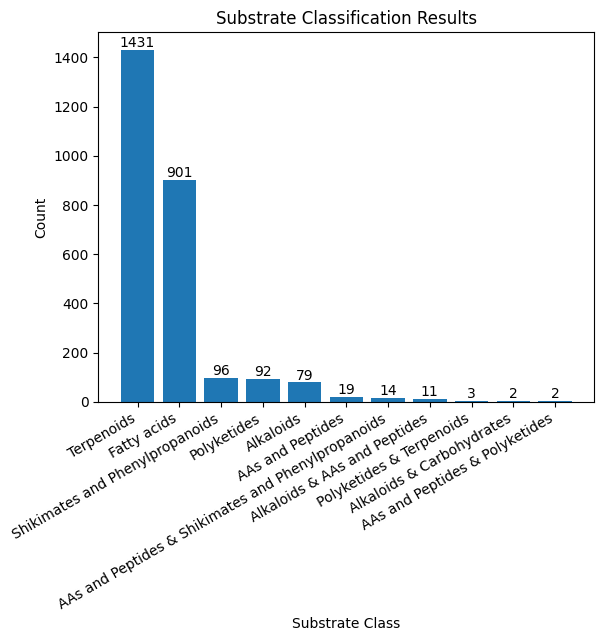

In [50]:
bars = plt.bar(labelsplt, values)
plt.xlabel("Substrate Class")
plt.ylabel("Count")
plt.xticks(rotation=30, ha='right')
plt.title("Substrate Classification Results")

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), value, ha='center', va='bottom')

plt.savefig("./img/subsClassification.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [51]:
alldf = pd.read_csv("cypsDB-new.csv")
alldf.columns

Index(['protein', 'name', 'reaction', 'rheaID', 'substrates',
       'Substrate CHEBI ID', 'Substrate SMILES', 'reducing_agent', 'cofactor',
       'products', 'Product CHEBI ID', 'Product SMILES', 'organism_name',
       'kingdom_name', 'superkingdom_name', 'sequence', 'length',
       'additional info'],
      dtype='object')

In [52]:
smiles_kingdom_df = alldf[['Substrate SMILES', 'kingdom_name']]
smiles_kingdom_df.columns = ['substrate_smiles', 'kingdom_name']
# dropping rows with empty smiles
smiles_kingdom_df = smiles_kingdom_df.dropna(subset='substrate_smiles')
# dropping rows with len(smiles)<5 
smiles_kingdom_df = smiles_kingdom_df[smiles_kingdom_df.substrate_smiles != '*[H]']
smiles_kingdom_df = smiles_kingdom_df[smiles_kingdom_df.substrate_smiles != 'O=O']
smiles_kingdom_df = smiles_kingdom_df.reset_index(drop=True)
smiles_kingdom_df

,substrate_smiles,kingdom_name
0,OCc1cccc(O)c1,Fungi
1,Cc1cccc(O)c1,Fungi
2,CC(C)c1ccc2c(CC[C@H]3C(C)(C)CCC[C@]23C)c1,Plantae
3,CC(C)c1cc2CC[C@H]3C(C)(C)CCC[C@]3(C)c2cc1O,Plantae
4,[H][C@@]12CCC3=C(CC=C(C3)C(C)C)[C@@]1(C)CCCC2(C)C,Plantae
...,...,...
2705,[H][C@@]12CC=C(C)[C@H](CO)[C@@]1(C)CCCC2(C)C,Plantae
2706,[H][C@@]1(C)C[C@@H](O)[C@]2([H])[C@]1([H])C[C@...,Bacteria
2707,O1C2=C(C(C(C1(C3=C(C=C(C=C3*)*)*)*)(*)*)=O)C(=...,Plantae
2708,O1C2=C(C(C(C1(C3=C(C=C(C=C3*)*)*)*)(*)*)=O)C(=...,Plantae


In [53]:
#dropping rows with indexes same as the not ok responses
smiles_kingdom_df = smiles_kingdom_df.drop([166, 167, 896, 2263])

In [54]:
smiles_kingdom_df.to_csv("smiles_kingdom.csv")
smiles_kingdom_df.shape

(2706, 2)

In [55]:
terpenoids_indexes = [i for i, response in enumerate(all_responses_list) if response['pathway_results'] == ['Terpenoids']]
print(terpenoids_indexes)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17, 18, 19, 20, 31, 32, 45, 46, 56, 61, 69, 70, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 93, 94, 95, 96, 99, 100, 101, 102, 103, 115, 116, 117, 118, 119, 120, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 149, 150, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 194, 195, 196, 197, 198, 199, 200, 212, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 256, 257, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 285, 286, 291, 292, 293, 294, 295, 296, 297, 309, 310, 311, 312, 313, 314, 315, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 356, 357, 362, 363, 364, 365, 366, 367, 368, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 417,

In [56]:
terpenoids_kingdoms = smiles_kingdom_df.iloc[terpenoids_indexes]['kingdom_name']

In [57]:
terpenoids_kingdom_counts = terpenoids_kingdoms.value_counts()
print(terpenoids_kingdom_counts)

Animalia        1024
Plantae          291
Bacteria          60
Fungi             50
Protista           5
Bamfordvirae       1
Name: kingdom_name, dtype: int64


In [58]:
terpenoids_kingdom_counts.index

Index(['Animalia', 'Plantae', 'Bacteria', 'Fungi', 'Protista', 'Bamfordvirae'], dtype='object')

In [59]:
subsClasses

allSubsClass_indexes = {}
for j, subsClass in enumerate(labels):
    allSubsClass_indexes[subsClass] = [i for i, response in enumerate(all_responses_list) if response['pathway_results'] == subsClasses[j]]
    new_values = allSubsClass_indexes[subsClass]
    if len(subsClasses[j]) == 2:
        if subsClasses[j][1] == 'Carbohydrates':
            continue
        allSubsClass_indexes[subsClasses[j][0]].extend(new_values)
        allSubsClass_indexes[subsClasses[j][1]].extend(new_values)
    # print(subsClass)
    # print(allSubsClass_indexes[subsClass])


In [60]:
allSubsClass_indexes_kingdoms = {}
allSubsClass_indexes_kingdom_counts = {}
for subsClass in labels:
    allSubsClass_indexes_kingdoms[subsClass] = smiles_kingdom_df.iloc[allSubsClass_indexes[subsClass]]['kingdom_name']
    allSubsClass_indexes_kingdom_counts[subsClass] = allSubsClass_indexes_kingdoms[subsClass].value_counts()

allSubsClass_indexes_kingdom_counts['Terpenoids']

kingdomClassCount = {}

for kingdom in terpenoids_kingdoms:
    vals =[]
    for subsClass in labels:
        if kingdom in allSubsClass_indexes_kingdom_counts[subsClass].index:
            vals.append(allSubsClass_indexes_kingdom_counts[subsClass][kingdom])
            kingdomClassCount[kingdom] = vals
        else:
            vals.append(0)
            kingdomClassCount[kingdom] = vals

#print(kingdomClassCount['Bamfordvirae'])

In [61]:
colors_dict = {'Animalia': '#FFA913', 'Plantae': '#0BB830', 'Fungi': '#FF4513', 'Bacteria': '#AD38FA', 'Protista': '#FFDF13','Bamfordvirae': '#5DADE2'}

In [62]:
for i in range(len(labelsplt)):
    if labelsplt[i] == 'Terpenoids':
        labelsplt[i] = 'Terpenoids and Steroids'

In [63]:
df = pd.DataFrame(data=kingdomClassCount, index=labelsplt)
df = df.iloc[:-5]



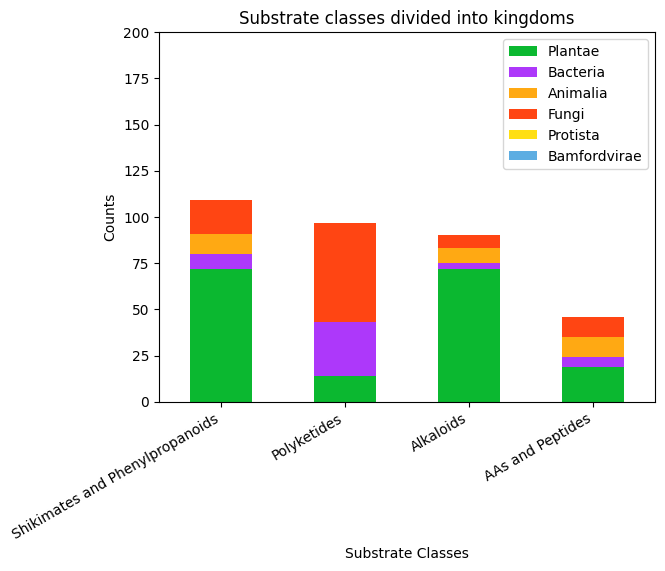

In [64]:
df_noTP = df.drop('Terpenoids and Steroids')
df_noTPFA = df_noTP.drop('Fatty acids')


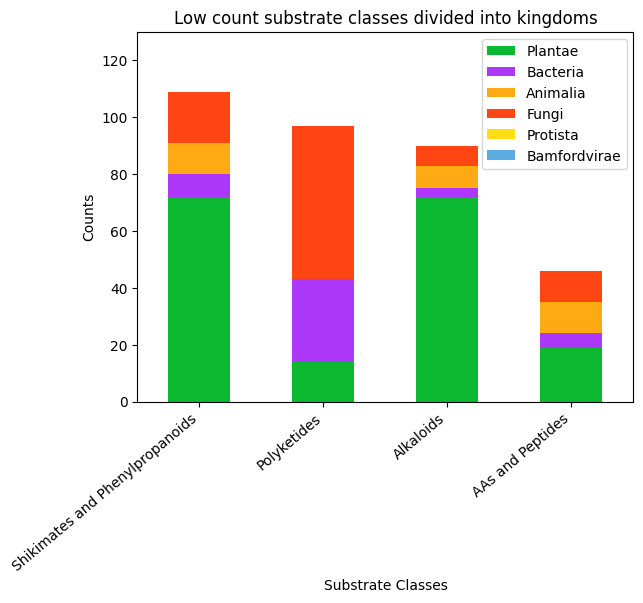

In [70]:
df_noTPFA.plot(kind='bar', stacked=True, color=colors_dict, ylim=(0,130))

plt.xlabel('Substrate Classes')
plt.xticks(rotation=40, ha='right')
plt.ylabel('Counts')

plt.title('Low count substrate classes divided into kingdoms')
plt.savefig("./img/subsClasses-kingdomsNEW.pdf", format="pdf", bbox_inches="tight")

KeyError: 'Bamfordvirae'

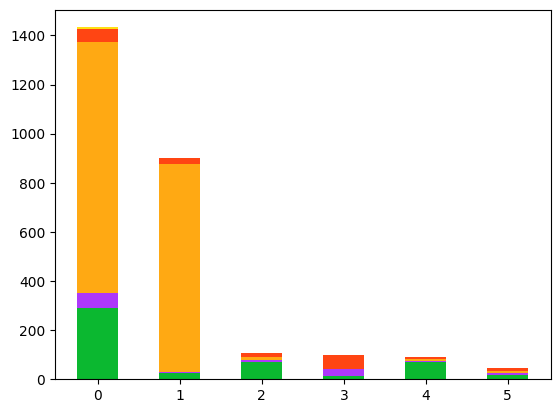

In [79]:
df.plot(kind='bar', stacked=True, color=colors_dict, ylim=(0,1500))

plt.xlabel('Substrate Classes')
plt.xticks(rotation=30, ha='right')
plt.ylabel('Counts')

plt.title('Substrate classes divided into kingdoms')
plt.savefig("./img/subsClasses-kingdomsNEWhigh.pdf", format="pdf", bbox_inches="tight")

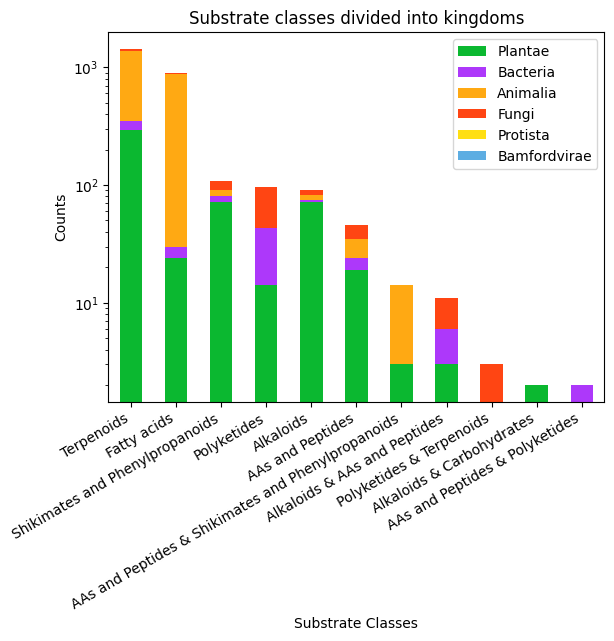

In [301]:
df = pd.DataFrame(data=kingdomClassCount, index=labelsplt)

df.plot(kind='bar', stacked=True, color=colors_dict)

plt.yscale('log') 
plt.xlabel('Substrate Classes')
plt.xticks(rotation=30, ha='right')
plt.ylabel('Counts')

plt.title('Substrate classes divided into kingdoms')
plt.savefig("./img/subsClasses-kingdoms-logscale.pdf", format="pdf", bbox_inches="tight")

In [74]:
df_wo_bam = df.drop('Bamfordvirae', axis=1)
print(df_wo_bam)

                                 Plantae  Bacteria  Animalia  Fungi  Protista
Terpenoids and Steroids              291        60      1024     53         5
Fatty acids                           24         6       846     25         0
Shikimates and Phenylpropanoids       72         8        11     18         0
Polyketides                           14        29         0     54         0
Alkaloids                             72         3         8      7         0
AAs and Peptides                      19         5        11     11         0


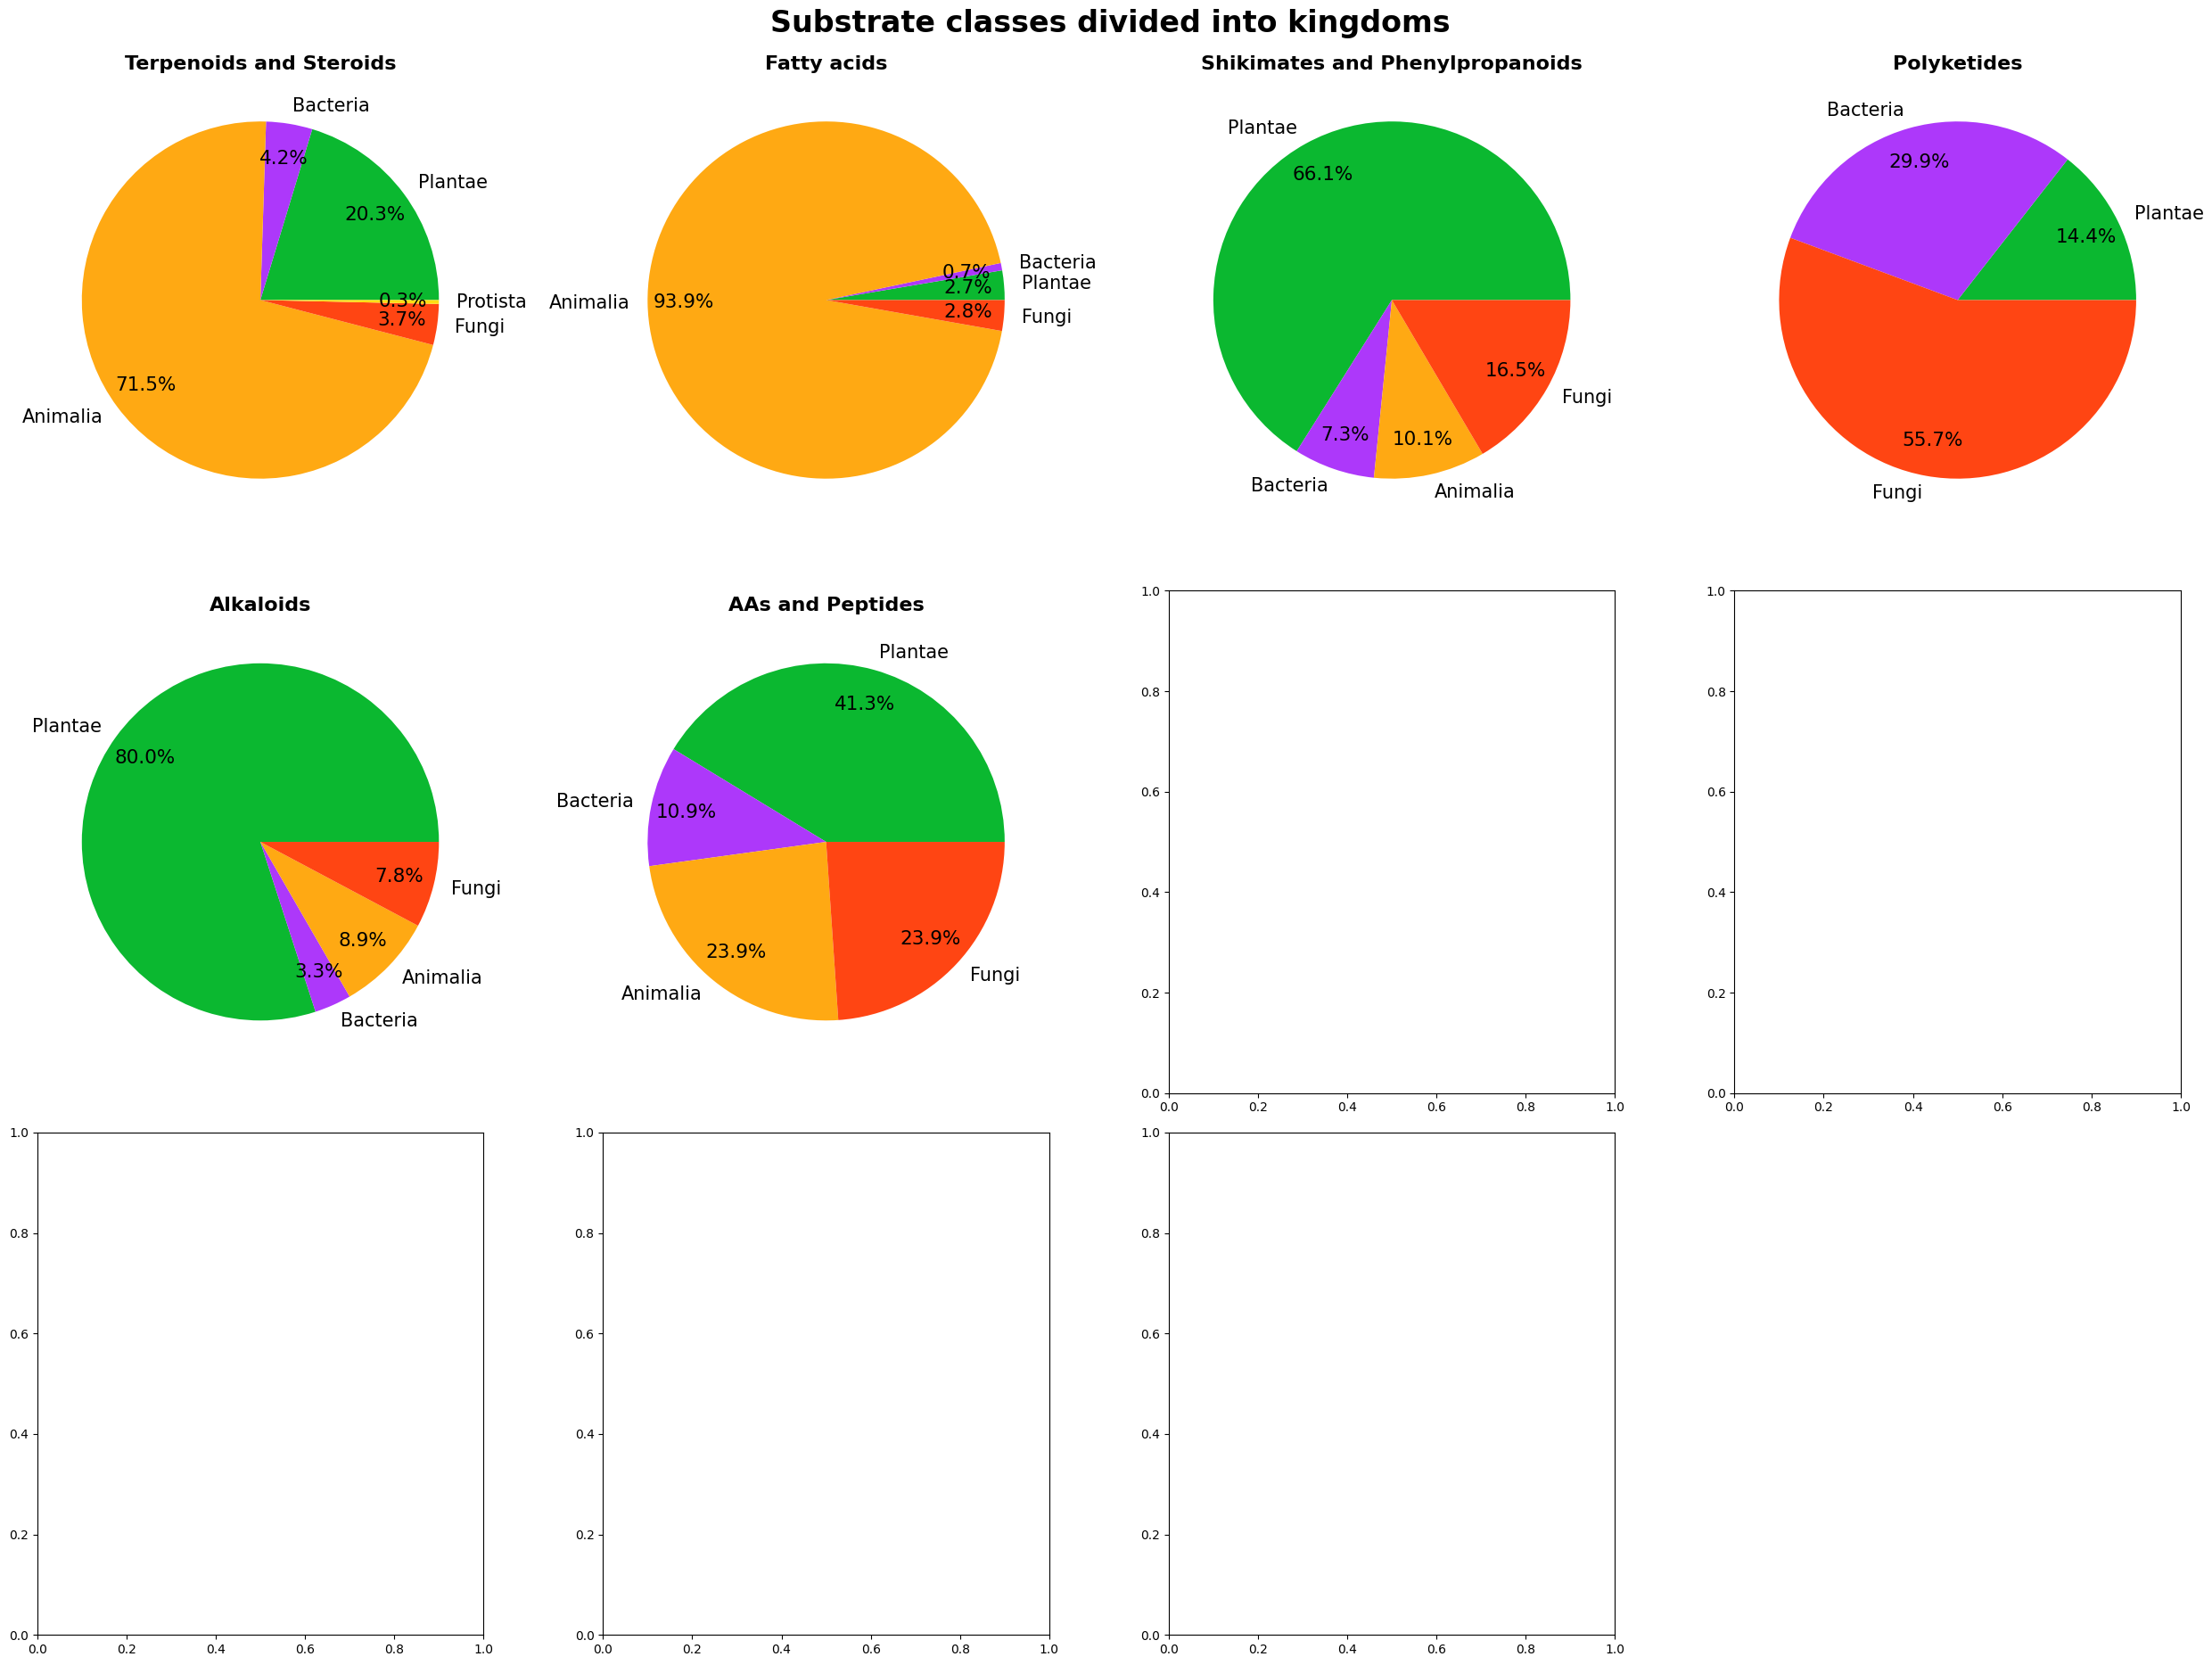

In [78]:
fig, axs = plt.subplots(nrows=3,ncols=4, figsize=(25,19))

colors_dict = {'Animalia': '#FFA913', 'Plantae': '#0BB830', 'Fungi': '#FF4513', 'Bacteria': '#AD38FA', 'Protista': '#FFDF13'}
for i, (idx, row) in enumerate(df_wo_bam.iterrows()):
    row = row[row != 0]

    x = i // 4
    y = i % 4
    
    _, texts, autotexts = axs[x][y].pie(row, labels=row.index, autopct='%1.1f%%', colors=[colors_dict.get(x, '#CCCCCC') for x in row.index], textprops={'fontsize':15.5}, pctdistance=0.8)
    for text in texts:
        text.set_fontsize(15)
    axs[x][y].set_title(idx, fontsize= 16, fontweight='bold')

plt.savefig("./img/subsClasses-kingdoms-pie.pdf", format="pdf", bbox_inches="tight")
plt.show()